In [11]:
# # run this once
# !git clone https://github.com/hughsalimbeni/bayesian_benchmarks.git
# !mv bayesian_benchmarks/bayesian_benchmarks tmp
# !rm -rf bayesian_benchmarks
# !mv tmp bayesian_benchmarks
!pip install xlrd openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 8.8 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['OMP_NUM_THREADS'] = '4'

from bayesian_benchmarks.data import get_regression_data, get_classification_data
import bayesian_benchmarks.data as bd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
from flax.training import train_state
import optax
from flax.training import train_state
import matplotlib.pyplot as plt


In [5]:
from flax import linen as nn
from typing import Callable

def count_params(model, x):
    params = model.init(jax.random.PRNGKey(0), x)
    n = sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])
    print(f'Number of parameters: {n/1e3} k')
    
def param_size(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])

def tree_norm(tree):
    return jnp.sqrt(sum([jnp.sum(x**2) for x in jax.tree_leaves(tree)]))

def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_unflatten(treedef, keys)

@jax.jit
def tree_random_normal_like(rng_key, target):
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree_map(
        lambda l, k: jax.random.normal(k, l.shape, l.dtype),
        target,
        keys_tree,
    )
    
@partial(jax.jit, static_argnums=(0,))
def laplacian_estimator(model, p, x, dp, sigma=1e-3):
    # dp: N(0, I)
    # p_perturbed = p + dp, both pytrees
    # scale dp by sigma
    dp = jax.tree_util.tree_map(lambda x: x * sigma, dp)
    p_perturbed = jax.tree_util.tree_map(lambda x, y: x + y, p, dp)
    # compute the difference between the outputs
    y = model.apply(p, x)
    y_perturbed = model.apply(p_perturbed, x)
    diff = y - y_perturbed
    # compute the avg sq norm of the difference
    avg_dff_sq_norm = jnp.mean((diff ** 2).sum(axis=-1))
    return avg_dff_sq_norm / (sigma ** 2)

def standardize(x_train, x_test):
    assert x_train.ndim == 2 and x_test.ndim == 2 and x_train.shape[1] == x_test.shape[1], 'x_train and x_test should have the same number of features'
    x_train = (x_train - x_train.mean(0)) / (x_train.std(0) + 1e-8)
    x_test = (x_test - x_train.mean(0)) / (x_train.std(0) + 1e-8)
    return x_train, x_test

def standardize_ds(x_train, y_train, x_test, y_test, is_classification):
    # X: (N, D)
    # Y: (N, Dy)
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    x_train, x_test = standardize(x_train, x_test)
    if is_classification:
        y_train = y_train.astype(np.int32)
        y_test = y_test.astype(np.int32)
    else:
        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)
        y_train, y_test = standardize(y_train, y_test)
    return x_train, y_train, x_test, y_test

class MLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    act: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.H)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, nn.Dense(self.H)]
        layers += [self.act, nn.Dense(self.out_size)]
        return nn.Sequential(layers)(x)

In [6]:
def optimize(train_loss_fn, test_loss_fn, neg_log_p_w_fn, n_train, init_params, lr, n_step, rng_key, model, x_eval_generator, optimizer, method, laplace_scale=1.0):    
    def get_train_state(optimizer, lr, init_params, warmup_steps=100):
        if optimizer == 'adam':
            tx = optax.chain(
                    optax.adam(learning_rate=lr),
                )
        elif optimizer == 'sgd':
            tx = optax.sgd(learning_rate=lr, momentum=0.9)
        else:
            raise NotImplementedError
        return train_state.TrainState.create(apply_fn=model.apply, params=init_params, tx=tx)
    
    ts = get_train_state(optimizer, lr, init_params)
    
    def augmented_loss_fn(p, x_eval, dp, rng_key):
        # loss = likelihood / n_train = 1 / (2 * sigma^2) * ||y - f(x)||^2 / n_train
        # it contains a factor 1 / n_train
        # all other terms should be divided by n_train as well
        avg_nll = train_loss_fn(p, rng_key) 
        test_loss = test_loss_fn(p)
        # number of params
        P = jax.tree_util.tree_leaves(p)[0].shape[0]
        if method == 'lmap':
            logdet = laplacian_estimator(model, p, x_eval, dp)
        elif method == 'psmap':
            logdet = 0
        else:
            raise NotImplementedError
        neg_log_p_w = neg_log_p_w_fn(p)
        logdet =  laplace_scale * logdet + (1 - laplace_scale) * jax.lax.stop_gradient(logdet)
        # return avg_nll + neg_log_p_w + logdet, (avg_nll, logdet, test_loss)
        return avg_nll + neg_log_p_w + logdet, (avg_nll, logdet, test_loss)

    grad_fn = jax.jit(jax.value_and_grad(lambda p, x_eval, dp, batch_key: augmented_loss_fn(p, x_eval, dp, batch_key), has_aux=True))
    losses = []
    logdets = []
    avg_nlls = []
    test_losss = []
    def sample_dp(p, rng_key):
        # gaussian tree
        dp = tree_random_normal_like(rng_key, p)
        return dp
    @jax.jit
    def train_step(ts, rng_key):
        rng_key, x_eval_key = jax.random.split(rng_key)
        x_eval = x_eval_generator(x_eval_key)
        rng_key, dp_key = jax.random.split(rng_key)
        dp = sample_dp(ts.params, dp_key)
        rng_key, batch_key = jax.random.split(rng_key)
        (loss, aux), grads = grad_fn(ts.params, x_eval, dp, batch_key)
        ts = ts.apply_gradients(grads=grads)
        return ts, loss, aux, rng_key
    for _ in tqdm(range(int(n_step))):
        ts, loss, aux, rng_key = train_step(ts, rng_key)
        avg_nll, logdet, test_loss = aux
        losses.append(loss.item())
        logdets.append(logdet.item())
        avg_nlls.append(avg_nll.item())
        test_losss.append(test_loss.item())
    losses = np.array(losses)
    logdets = np.array(logdets)
    avg_nlls = np.array(avg_nlls)
    test_losss = np.array(test_losss)
    
    return ts.params, losses, avg_nlls, logdets, test_losss

In [7]:
import time

def to_one_hot(y_train, y_val, y_test):
    # y_train: (N,1)
    # y_test: (N,1)
    assert y_train.ndim == 2 and y_test.ndim == 2 and y_train.shape[1] == y_test.shape[1] == 1, 'y_train and y_test should have shape (N,1)'
    n_classes = y_train.max() + 1
    y_train = jax.nn.one_hot(y_train.reshape(-1), n_classes)
    y_val = jax.nn.one_hot(y_val.reshape(-1), n_classes)
    y_test = jax.nn.one_hot(y_test.reshape(-1), n_classes)
    return y_train, y_val, y_test

def run_dataset(dataset, arch, wd, n_step, batch_size, lr, optimizer, output_dir, seed, method, laplace_scale, p_X='noise', result_path=None):
    is_classification = dataset in bd.classification_datasets
    if is_classification:
        print(f'Running {dataset} classification dataset')
    else:
        print(f'Running {dataset} regression dataset')
    # get data
    ds = get_regression_data(dataset) if not is_classification else get_classification_data(dataset)
    x_train, y_train, x_test, y_test = ds.X_train, ds.Y_train, ds.X_test, ds.Y_test
    if seed != 0:
        # shuffle train and test since UCI has high variance across splits
        x_combined = np.concatenate([x_train, x_test], axis=0)
        y_combined = np.concatenate([y_train, y_test], axis=0)
        indices = np.arange(x_combined.shape[0])
        np.random.seed(seed)
        np.random.shuffle(indices)
        x_combined = x_combined[indices]
        y_combined = y_combined[indices]
        x_train, x_test = x_combined[:x_train.shape[0]], x_combined[x_train.shape[0]:]
        y_train, y_test = y_combined[:y_train.shape[0]], y_combined[y_train.shape[0]:]
        
    x_train, y_train, x_test, y_test = standardize_ds(x_train, y_train, x_test, y_test, is_classification)
    # 10% of training data as validation
    n_val = int(x_train.shape[0] * 0.1)
    # shuffle x_train and y_train
    indices = np.arange(x_train.shape[0])
    # fix seed
    np.random.seed(42)
    np.random.shuffle(indices)
    x_train = jnp.asarray(x_train[indices])
    y_train = jnp.asarray(y_train[indices])
    x_train, x_val, y_train, y_val = x_train[n_val:], x_train[:n_val], y_train[n_val:], y_train[:n_val]
    if is_classification:
        y_train, y_val, y_test = to_one_hot(y_train, y_val, y_test)
    print(f"X train: {x_train.shape}, X val: {x_val.shape}, X test: {x_test.shape}")
    print(f"Y train: {y_train.shape}, Y val: {y_val.shape}, Y test: {y_test.shape}")
    # model
    model = arch(out_size=y_train.shape[1])
    def x_eval_generator(rng_key):
        # sample batch_size points from training set
        if p_X == 'train':
            ind = jax.random.randint(rng_key, (batch_size,), 0, x_train.shape[0])
            return x_train[ind]
        elif p_X == 'noise':
            return jax.random.normal(rng_key, (batch_size, x_train.shape[1]))
        else:
            raise ValueError(f'p_X should be either train or noise, got {p_X}')
        
    # count parameters
    init_params = model.init(jax.random.PRNGKey(0), jnp.ones((1, x_train.shape[1])))
    leaves, _ = jax.tree_util.tree_flatten(init_params)
    n_params = sum([np.prod(p.shape) for p in leaves])
    print(f"Number of parameters: {n_params}")

    # softmax multi-task cross entropy loss (not binary)
    if is_classification:
        loss_fn = lambda p, x, y: jnp.mean(jnp.sum(-jax.nn.log_softmax(model.apply(p, x), axis=1) * y, axis=1))
    else:
        loss_fn = lambda p, x, y: jnp.mean((model.apply(p, x) - y)**2)
    y_model = model.apply(init_params, x_test)
    assert y_model.shape == y_test.shape, f'model output shape: {y_model.shape}, y_test shape: {y_test.shape}'
    def train_loss_fn(p, rng_key):
        ind = jax.random.randint(rng_key, (batch_size,), 0, x_train.shape[0])
        return loss_fn(p, x_train[ind], y_train[ind])
        # return loss_fn(p, x_train, y_train)
    test_loss_fn = lambda p: loss_fn(p, x_test, y_test)
    val_loss_fn = lambda p: loss_fn(p, x_val, y_val)
    
    rng_key = jax.random.PRNGKey(seed)
    # log training time
    start_time = time.time()
    
    # params, losses, avg_losses, val_losses, logdets = optimize(lr, prior_scale, n_step, rng_key, train_loss_fn, val_loss_fn, model, x_train, y_train, x_eval_generator, optimizer, fsmap, jitter, method, laplace_scale)
    
    neg_log_p_w_fn = lambda p: jnp.sum((jax.flatten_util.ravel_pytree(p)[0] ** 2)) * wd
    n_train = x_train.shape[0]
    params, losses, avg_losses, logdets, test_losses = optimize(train_loss_fn, test_loss_fn, neg_log_p_w_fn, n_train, init_params, lr, n_step, rng_key, model, x_eval_generator, optimizer, method, laplace_scale)
    
    end_time = time.time()
    # train time in seconds
    train_time = end_time - start_time
    # plot and save losses
    plt.figure()
    
    def make_subplots(arrays, labels):
        n_plots = len(arrays)
        fig, axs = plt.subplots(n_plots, 1, figsize=(5, 5))
        for i, (a, label) in enumerate(zip(arrays, labels)):
            q1, q2 = np.quantile(a, [0., 1])
            axs[i].plot(a)
            axs[i].set_ylim(q1, q2)
            axs[i].set_xlabel('Step')
            axs[i].set_ylabel(label)
            axs[i].legend()
        plt.show()
    
    make_subplots([avg_losses, test_losses, logdets], ['Train Loss', 'Test Loss', 'Logdet'])
    
    
    train_rmse = lambda p: jnp.sqrt(jnp.mean((model.apply(p, x_train) - y_train) ** 2))
    val_rmse = lambda p: jnp.sqrt(jnp.mean((model.apply(p, x_val) - y_val) ** 2))
    test_rmse = lambda p: jnp.sqrt(jnp.mean((model.apply(p, x_test) - y_test) ** 2))
    
    def measure(params):
        measurements = {
            'train_rmse': train_rmse(params).item(),
            'val_rmse': val_rmse(params).item(),
            'test_rmse': test_rmse(params).item(),
            'train_time': train_time,
            'laplace_scale': laplace_scale,
            'wd': wd,
            'dataset': dataset,
        }
        print(measurements)
        # return log_likelihood + neg_log_param_prior - 1 / 2 * log_det
        return measurements
    
    measurements = measure(params)
    torch.save(measurements, result_path)

    return measurements

Loaded result from  uci/psmap/boston_mlp_wd9.999999999999999e-06.seed0.pt
Loaded result from  uci/psmap/boston_mlp_wd9.999999999999999e-05.seed0.pt
Loaded result from  uci/psmap/boston_mlp_wd0.001.seed0.pt
Loaded result from  uci/psmap/boston_mlp_wd0.01.seed0.pt
Loaded result from  uci/psmap/boston_mlp_wd0.09999999999999999.seed0.pt
Loaded result from  uci/psmap/concrete_mlp_wd9.999999999999999e-06.seed0.pt
Loaded result from  uci/psmap/concrete_mlp_wd9.999999999999999e-05.seed0.pt
Loaded result from  uci/psmap/concrete_mlp_wd0.001.seed0.pt
Loaded result from  uci/psmap/concrete_mlp_wd0.01.seed0.pt
Loaded result from  uci/psmap/concrete_mlp_wd0.09999999999999999.seed0.pt
Running energy regression dataset
X train: (622, 8), X val: (69, 8), X test: (77, 8)
Y train: (622, 1), Y val: (69, 1), Y test: (77, 1)
Number of parameters: 134145


100%|██████████| 10000/10000 [01:35<00:00, 104.54it/s]
/tmp/ipykernel_191575/2629192945.py:103: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[i].set_ylim(q1, q2)


<Figure size 640x480 with 0 Axes>

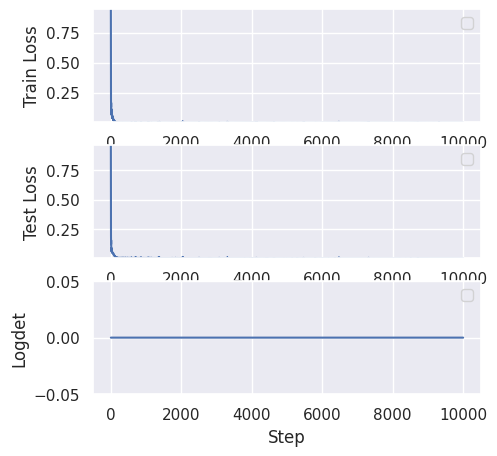

{'train_rmse': 0.009090150706470013, 'val_rmse': 0.037204448133707047, 'test_rmse': 0.033947985619306564, 'train_time': 95.68962073326111, 'laplace_scale': 0, 'wd': 9.999999999999999e-06, 'dataset': 'energy'}
Running energy regression dataset
X train: (622, 8), X val: (69, 8), X test: (77, 8)
Y train: (622, 1), Y val: (69, 1), Y test: (77, 1)
Number of parameters: 134145


 41%|████      | 4101/10000 [00:39<00:55, 106.80it/s]

In [12]:
# PSMAP

width = 256
depth = 3


optimizer = 'adam'
lr = 1e-3
n_step = int(1e4)
batch_size = 512
wds = np.logspace(-5, -1, 5)


skip_if_done = True
method = 'psmap'

datasets = ['boston', 'concrete', 'energy', 'power', 'protein', 'winered', 'winewhite', 'naval']

# tune weight decay (i.e. prior scale)
psmap_results = []
output_dir = f'uci/{method}'
# mkdir if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for dataset in datasets:
    for wd in wds:
        for seed in range(1):
            arch = partial(MLP, H=width, hidden_layers=depth)
            result_path = f'{output_dir}/{dataset}_mlp_wd{wd}.seed{seed}.pt'
            if os.path.exists(result_path) and skip_if_done:
                psmap_results.append(torch.load(result_path))
                print('Loaded result from ', result_path)
            else:
                psmap_results.append(run_dataset(dataset, arch, wd, n_step, batch_size, lr, optimizer, output_dir, seed, method=method, laplace_scale=0, result_path=result_path))

# run with best wd
output_dir = f'uci/{method}'
psmap_results = []
for dataset in datasets:
    best_wd = None
    best_val_rmse = float('inf')
    for wd in wds:
        result_path = f'{output_dir}/{dataset}_mlp_wd{wd}.seed0.pt'
        val_rmse = torch.load(result_path)['val_rmse']
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_wd = wd
    print(f'Best wd for {dataset} is {best_wd}')
    arch = partial(MLP, H=width, hidden_layers=depth)
    for seed in range(6):
        result_path = f'{output_dir}/{dataset}_mlp_best.seed{seed}_shuffled.pt'
        if os.path.exists(result_path) and skip_if_done:
            psmap_results.append(torch.load(result_path))
        else:
            psmap_results.append(run_dataset(dataset, arch, best_wd, n_step, batch_size, lr, optimizer, output_dir, seed, method=method, laplace_scale=0, result_path=result_path))

In [ ]:
# LMAP

width = 256
depth = 3


optimizer = 'adam'
lr = 1e-3
n_step = int(1e4)
batch_size = 512
wds = np.logspace(-5, -1, 5)
laplace_scales = np.logspace(-5, -1, 5)


skip_if_done = True
method = 'lmap'

datasets = ['boston', 'concrete', 'energy', 'power', 'protein', 'winered', 'winewhite', 'naval']

# tune weight decay (i.e. prior scale) and laplace scale
lmap_results = []
output_dir = f'uci/{method}'
# mkdir if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for dataset in datasets:
    for wd in wds:
        for laplace_scale in laplace_scales:
            for seed in range(1):
                arch = partial(MLP, H=width, hidden_layers=depth)
                result_path = f'{output_dir}/{dataset}_mlp_pXnoise.l{laplace_scale}.wd{wd}.seed{seed}.pt'
                if os.path.exists(result_path) and skip_if_done:
                    lmap_results.append(torch.load(result_path))
                    print('Loaded result from ', result_path)
                else:
                    gt_params = None
                    lmap_results.append(run_dataset(dataset, arch, wd, n_step, batch_size, lr, optimizer, output_dir, seed, method=method, laplace_scale=laplace_scale, result_path=result_path))

# run with best wd and laplace scale      
output_dir = f'uci/{method}'                    
lmap_results = []
for dataset in datasets:
    best_wd = None
    best_laplace_scale = None
    best_val_rmse = float('inf')
    for wd in wds:
        for laplace_scale in laplace_scales:
            result_path = f'{output_dir}/{dataset}_mlp_pXnoise.l{laplace_scale}.wd{wd}.seed0.pt'
            val_rmse = torch.load(result_path)['val_rmse']
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_wd = wd
                best_laplace_scale = laplace_scale
    print(f'Best wd, laplace_scale for {dataset} is ({best_wd}, {best_laplace_scale})')
    arch = partial(MLP, H=width, hidden_layers=depth)
    for seed in range(6):
        result_path = f'{output_dir}/{dataset}_mlp_best.seed{seed}_shuffled.pt'
        if os.path.exists(result_path) and skip_if_done:
            lmap_results.append(torch.load(result_path))
        else:
            lmap_results.append(run_dataset(dataset, arch, best_wd, n_step, batch_size, lr, optimizer, output_dir, seed, method=method, laplace_scale=best_laplace_scale, result_path=result_path))